<h1> Imports </h1>

In [354]:

import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.morphology import binary_erosion, binary_dilation, binary_closing,skeletonize, thin
from skimage.measure import find_contours
from skimage.draw import rectangle
import cv2
from joblib import load

# Utilities

In [355]:
# Show the figures / plots inside the notebook
def show_images(images,titles=None):
    #This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        plt.axis('off')
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show() 
    
def mapClassToChar(charClass):
    return CLASS_ARA[charClass]

<h1> Loading the mode </h1>

In [356]:
#load the trained model if exists else train
if not os.path.isfile('model.joblib'):
    print("ERROR : NO MODEL IMPORTED")
    quit()    
else:
    model = load('model.joblib')

# CONSTANTS

In [357]:
PADDING=6
PLATE_WIDTH=1200  
MIN_CHAR_RATIO=0.12
MAX_CHAR_RATIO=1.1   
CHARACTER_DIM=(40,40)
CLASS_ARA= {
    '0': '٠', '1': '١', '2': '٢', '3': '٣', '4': '٤', '5': '٥', '6': '٦', '7': '٧', '8': '٨', '9': '٩',
    'alf':'أ','beh':'ب','dal':'د','fa2':'ف','gem':'ج','hah':'ح','heh':'ه','kaf':'ق','kha':'خ','lam':'ل','mem':'م','non':'ن','ra2':'ر','sad':'ص','sen':'س','ta2':'ط','wow':'و','ya2':'ى',
    '3en':'ع',
}    

In [358]:
def resizePlate(img):
    """
        resize plate to constant width
    """
    factor=PLATE_WIDTH/img.shape[0]
    width=int(img.shape[0]*factor)
    height=int(img.shape[1]*factor)

    dim = ( height ,width  )
    return cv2.resize(img,dim, interpolation = cv2.INTER_AREA)

In [359]:
def preProcessPlate(img):

    blur = cv2.GaussianBlur(img, (3,3), 0)

    # Performing OTSU threshold
    ret, thresh1 = cv2.threshold(blur, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    # thresh1=cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_MEAN_C ,cv2.THRESH_BINARY_INV,61,15)

    # Specify structure shape and kernel size.
    # Kernel size increases or decreases the area
    # of the rectangle to be detected.
    # A smaller value like (10, 10) will detect
    # each word instead of a sentence.
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 75))

    # Applying dilation on the threshold image
    dilation = cv2.dilate(thresh1, rect_kernel, iterations = 1)
    
    return dilation

In [360]:
def segmentPlate(image,cropFrom):
    """
        img is the image after preprocessing 
        cropFrom the image to take characters from
    """
    # Finding contours
    contours, hierarchy = cv2.findContours(image, cv2.RETR_TREE,
                                                    cv2.CHAIN_APPROX_NONE)
    
    contours = sorted(contours, key=lambda tup: cv2.boundingRect(tup)[0])
    chars=[]

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if not( x > PADDING and y > PADDING):
            continue

        x-=PADDING
        y-=PADDING
        w+=2*PADDING
        h+=2*PADDING

        if(w/h> MIN_CHAR_RATIO and w/h < MAX_CHAR_RATIO): #Contour evaluation
            # Cropping the text block for giving input to OCR
           
            cropped = cropFrom[y:y + h, x:x + w]
            if cropped.shape[0]>0 and cropped.shape[1]>0:
                chars.append(cropped)
                show_images([cropped])
    return chars


In [361]:
def recognizeChar(img):
    image = cv2.resize(img,CHARACTER_DIM)/255
    imgFeatures=[image.flatten()]

    model_classes = model.classes_
    predicted = model.predict(imgFeatures)
    score = model.predict_proba(imgFeatures)

    index = np.where(model_classes == predicted[0])[0][0]
    predicted = predicted[0]
    score = score[0][index]
    return predicted,score


In [362]:
def readPlate(image):
    plateImage=resizePlate(image)  
    preprocessed=preProcessPlate(plateImage)
    show_images([preprocessed])
    segments=segmentPlate(preprocessed,plateImage)
    text=""
    for segment in segments:
        char,score=recognizeChar(segment)
        if score > .7:
            text+=mapClassToChar(char)+' '
    if text == "":
        return "??"
    else:
        return text[::-1] # reverse String


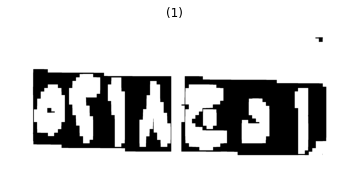

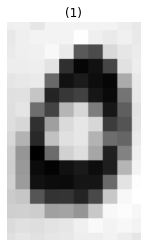

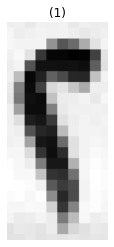

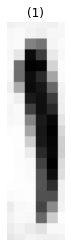

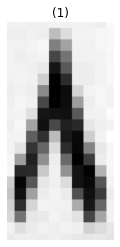

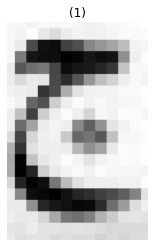

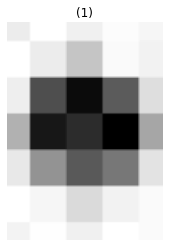

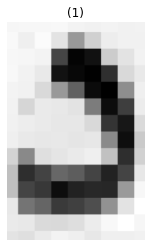

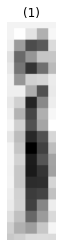

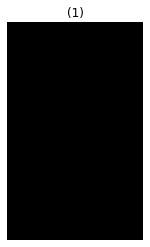

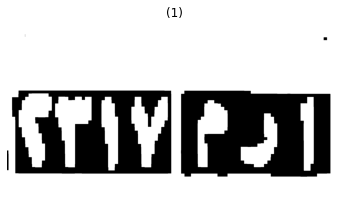

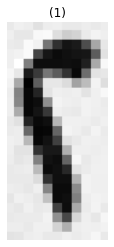

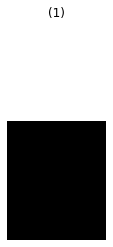

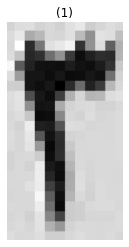

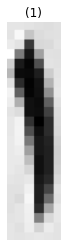

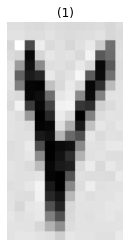

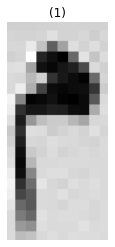

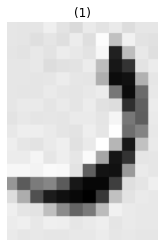

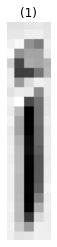

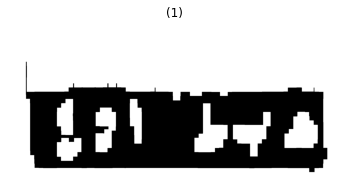

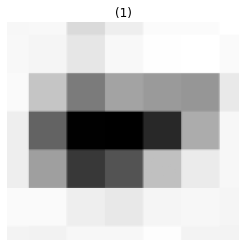

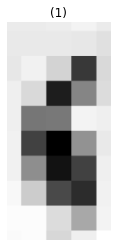

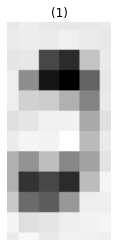

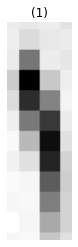

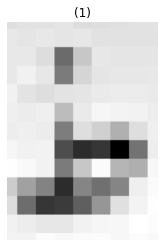

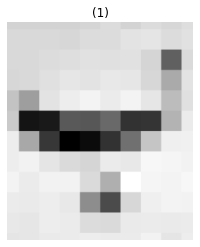

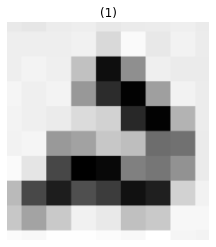

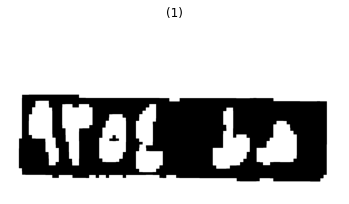

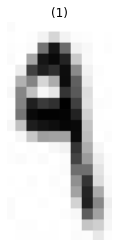

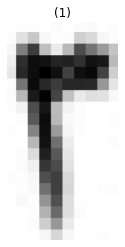

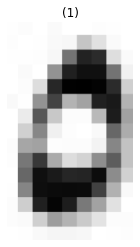

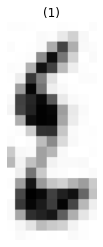

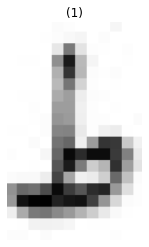

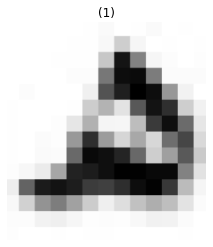

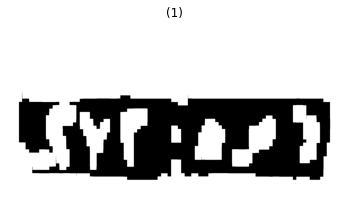

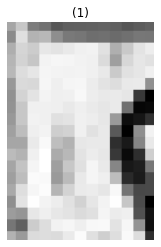

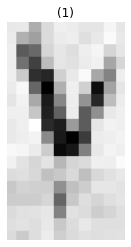

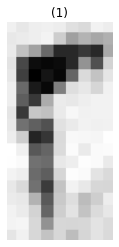

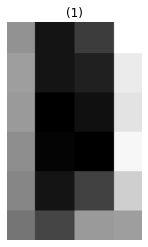

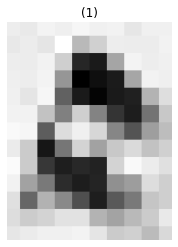

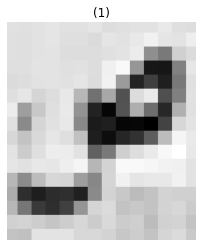

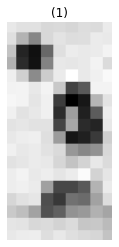

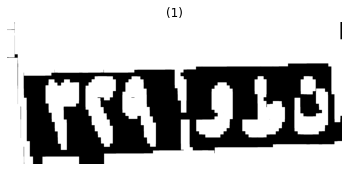

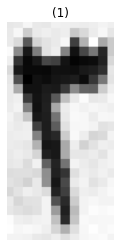

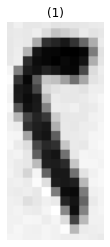

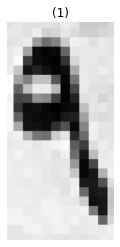

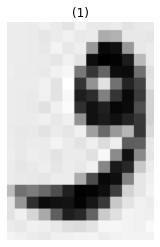

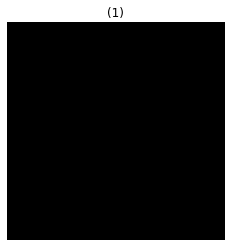

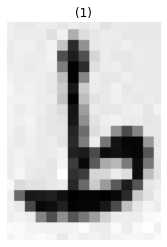

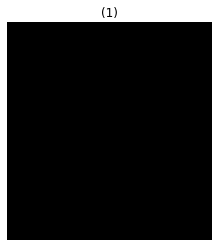

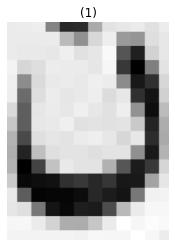

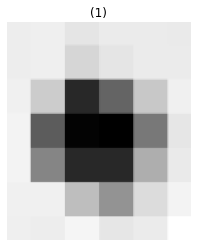

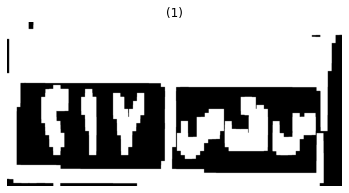

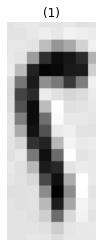

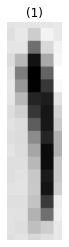

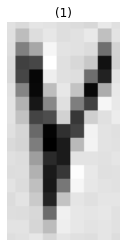

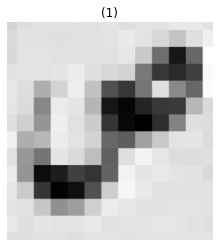

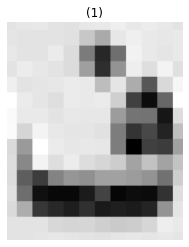

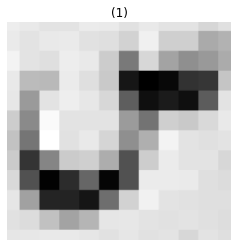

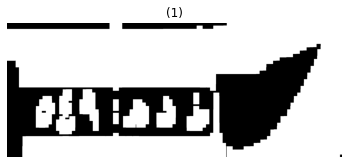

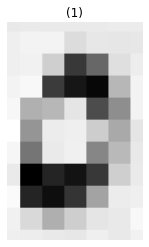

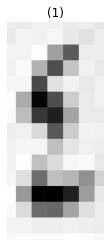

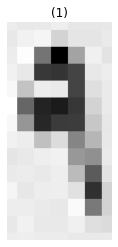

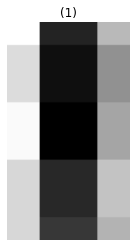

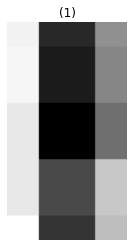

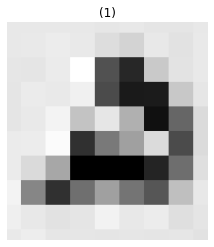

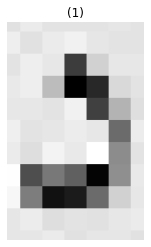

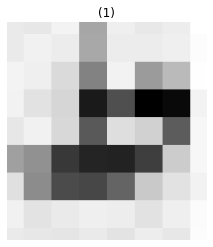

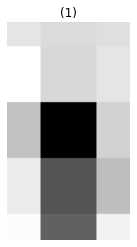

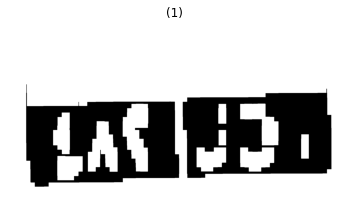

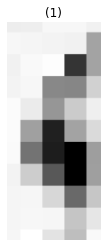

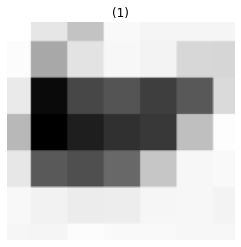

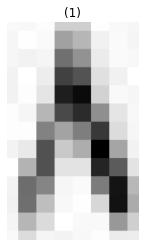

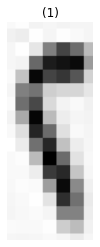

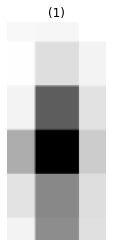

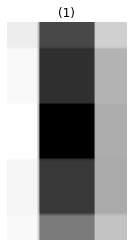

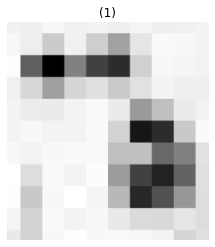

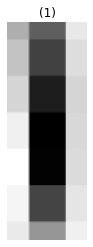

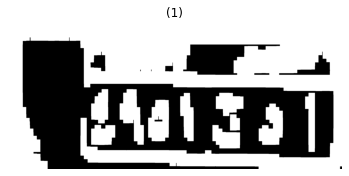

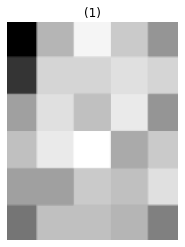

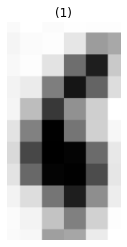

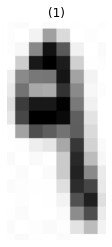

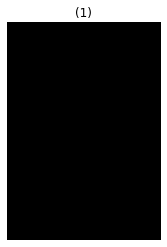

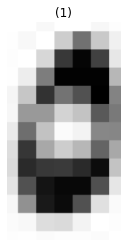

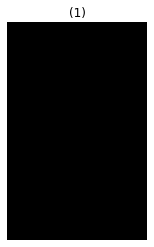

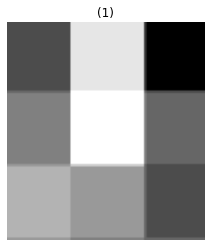

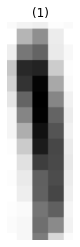

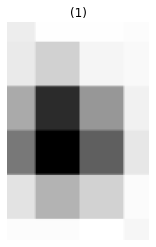

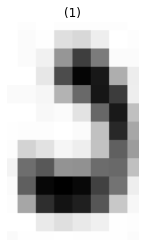

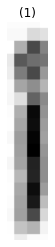

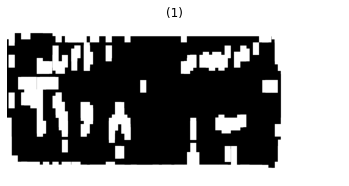

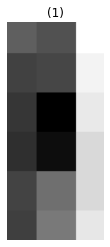

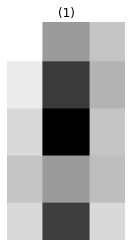

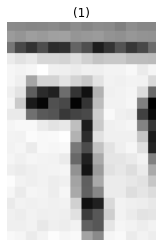

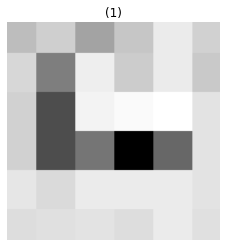

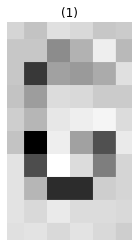

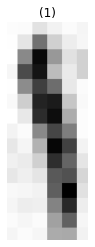

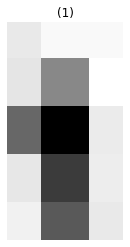

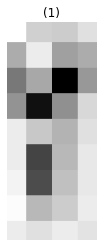

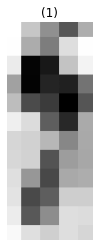

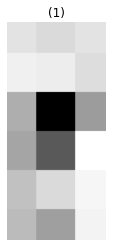

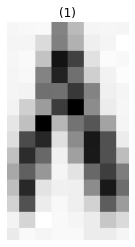

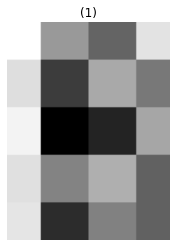

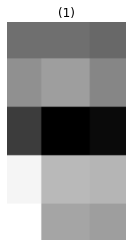

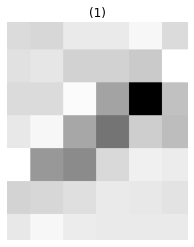

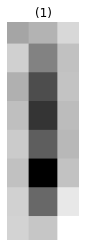

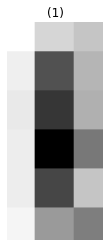

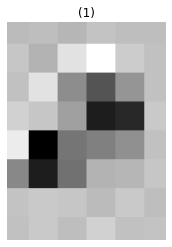

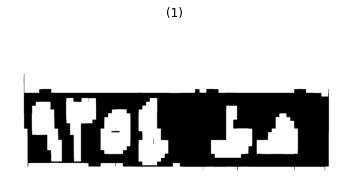

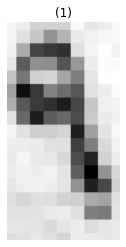

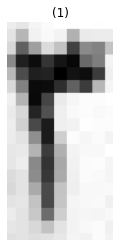

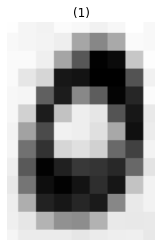

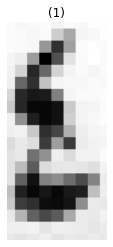

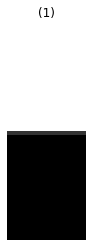

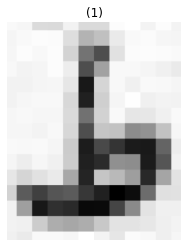

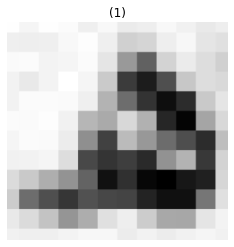

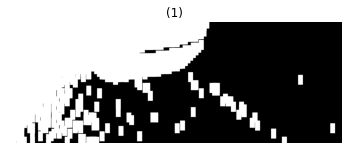

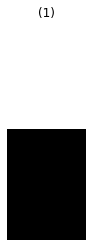

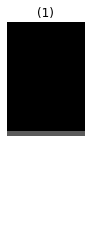

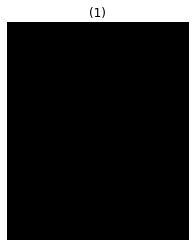

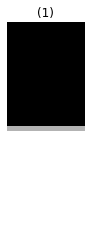

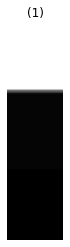

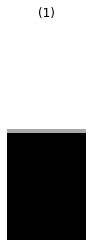

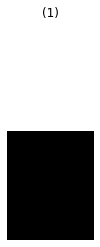

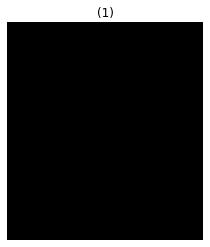

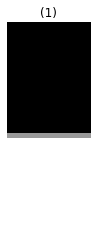

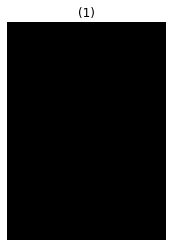

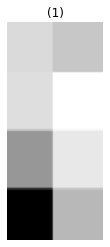

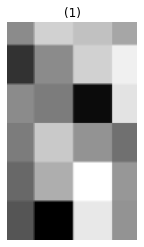

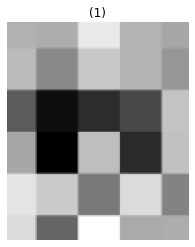

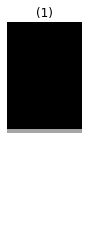

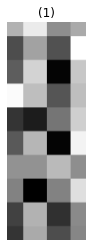

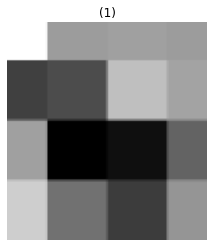

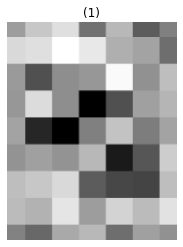

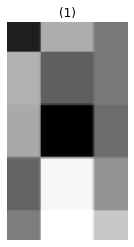

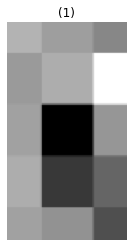

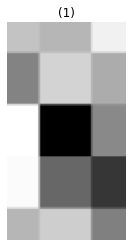

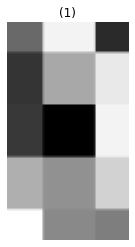

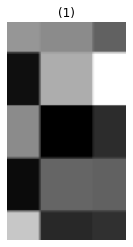

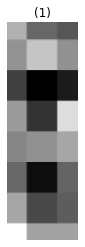

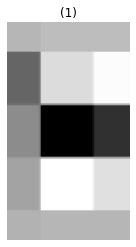

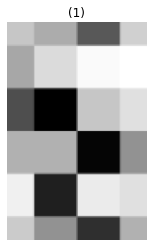

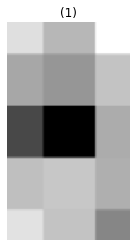

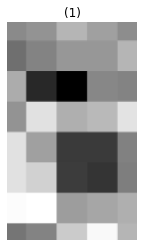

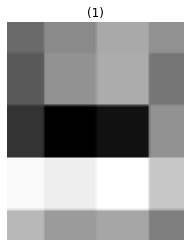

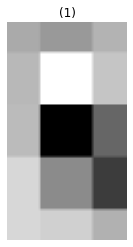

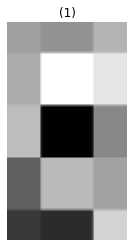

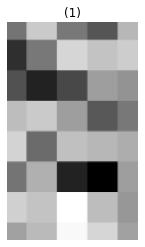

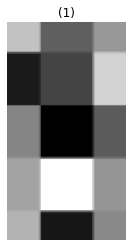

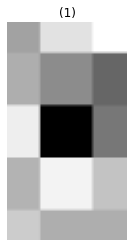

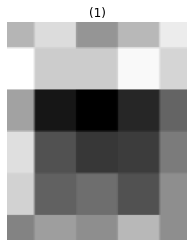

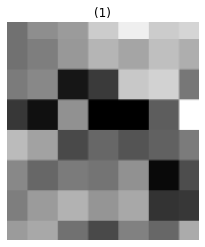

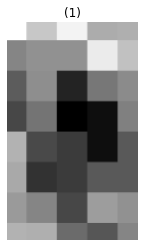

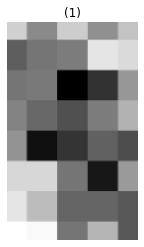

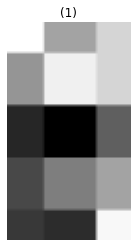

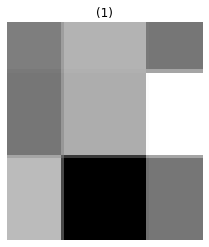

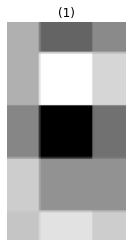

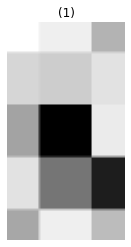

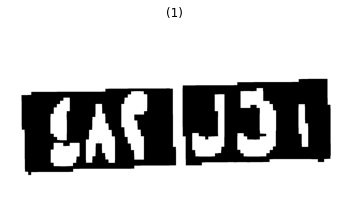

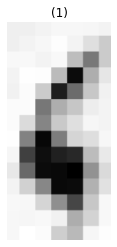

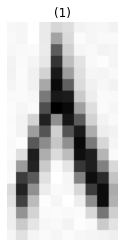

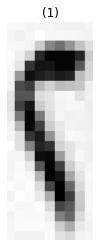

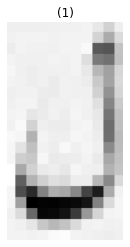

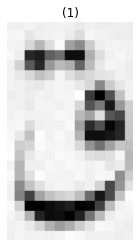

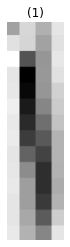

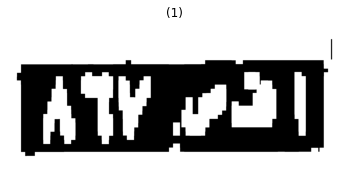

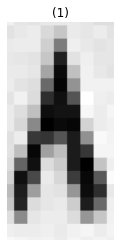

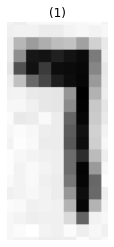

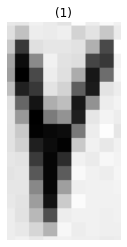

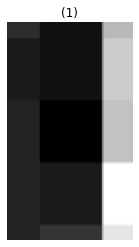

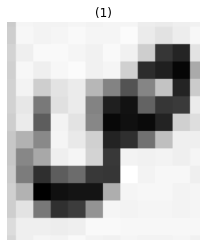

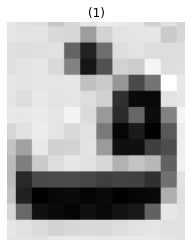

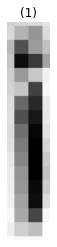

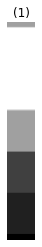

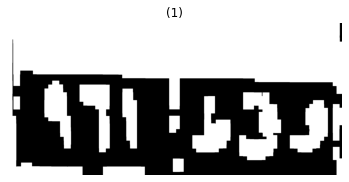

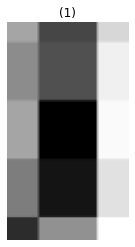

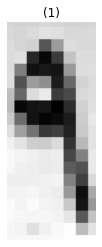

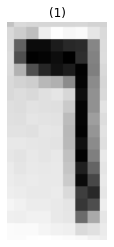

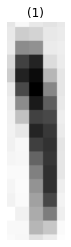

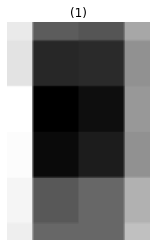

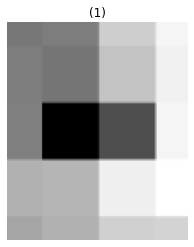

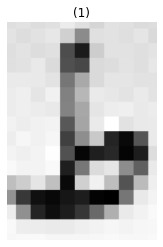

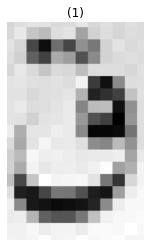

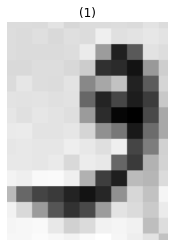

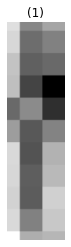

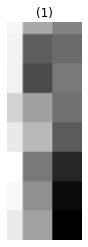

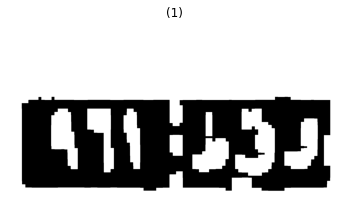

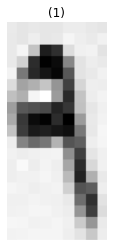

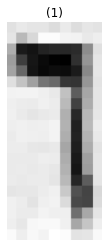

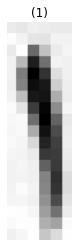

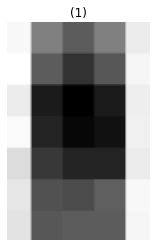

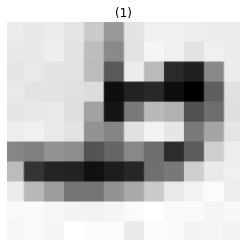

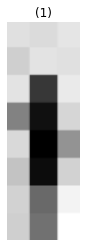

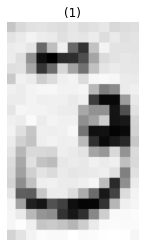

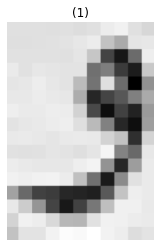

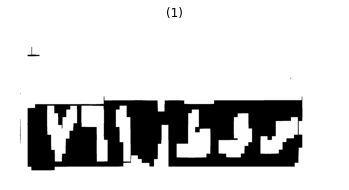

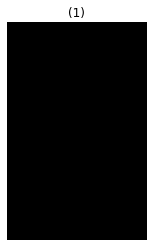

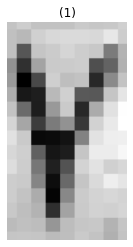

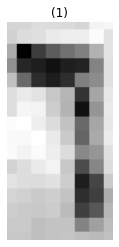

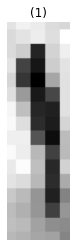

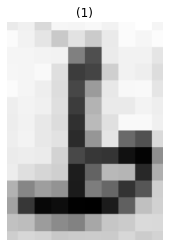

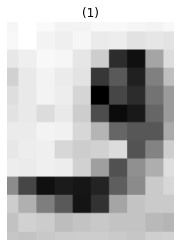

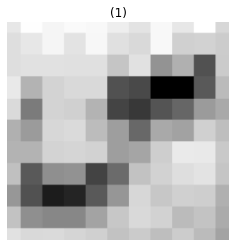

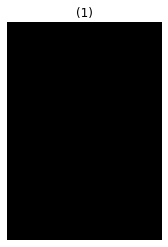

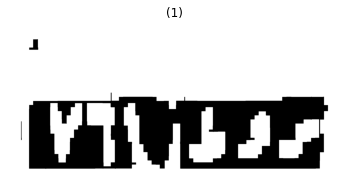

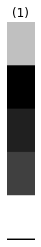

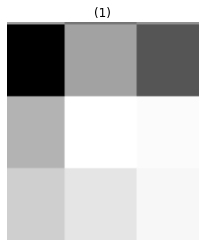

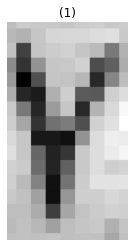

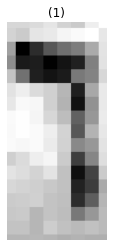

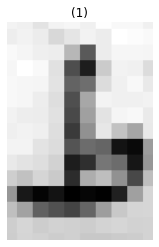

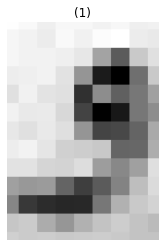

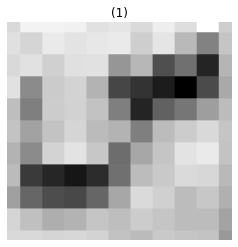

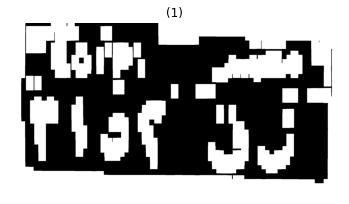

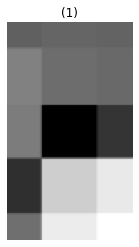

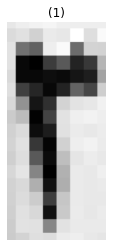

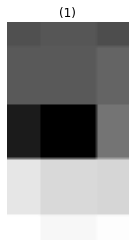

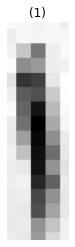

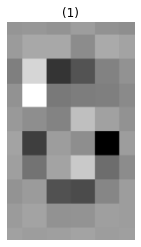

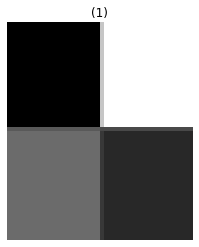

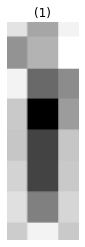

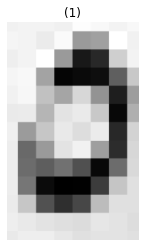

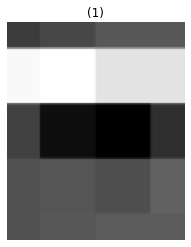

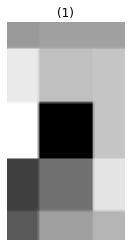

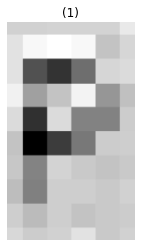

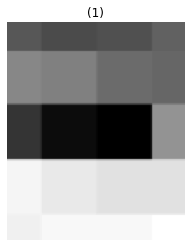

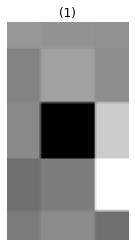

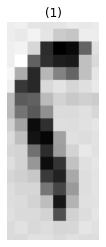

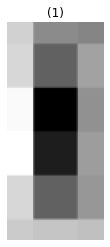

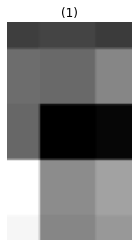

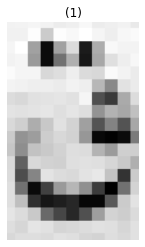

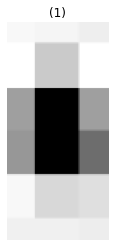

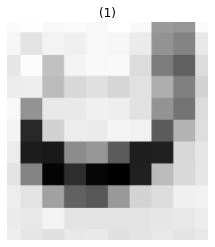

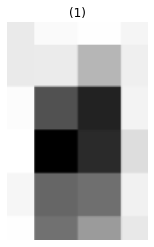

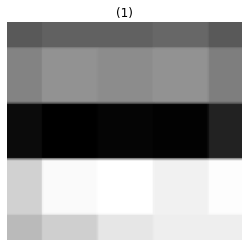

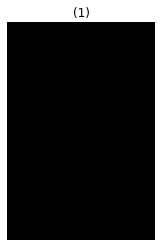

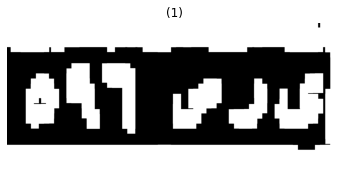

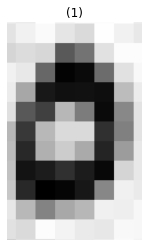

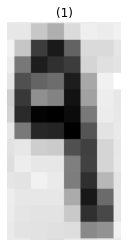

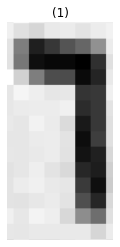

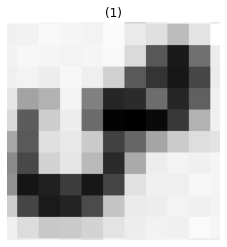

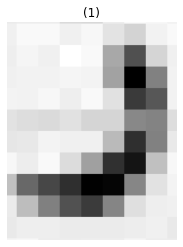

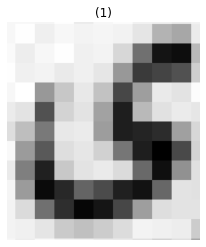

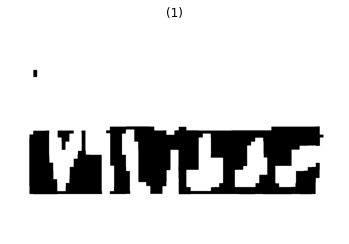

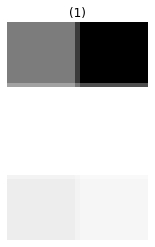

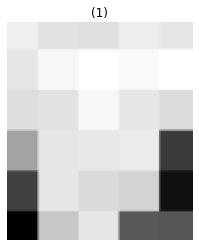

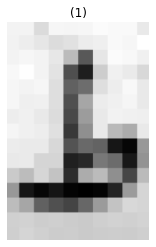

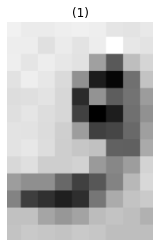

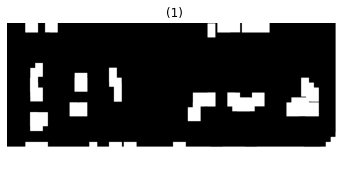

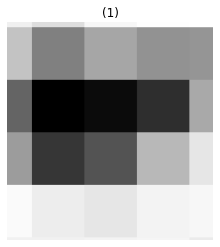

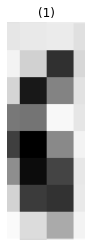

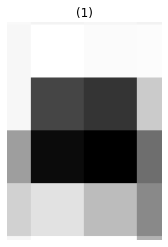

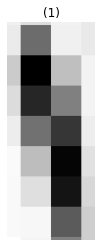

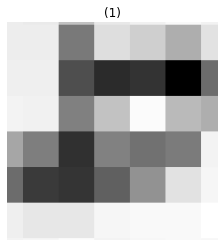

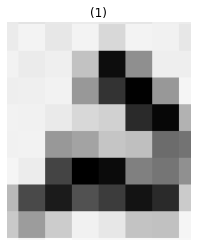

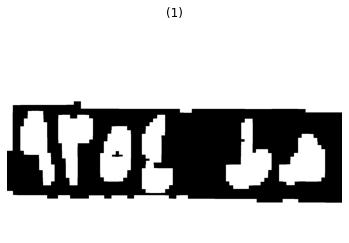

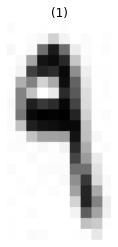

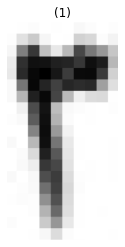

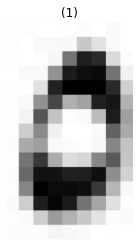

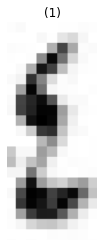

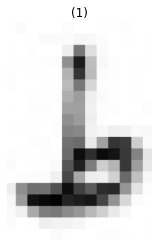

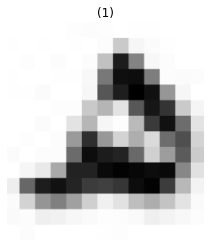

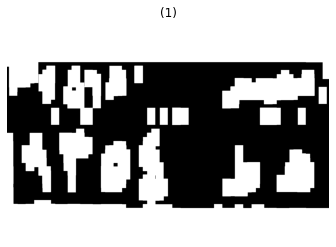

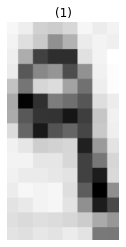

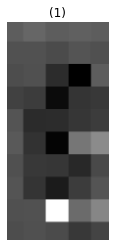

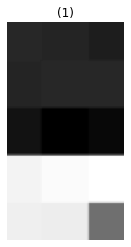

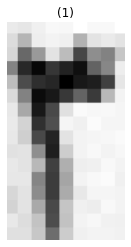

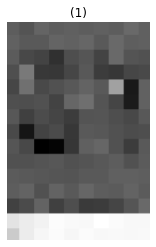

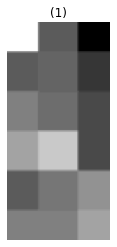

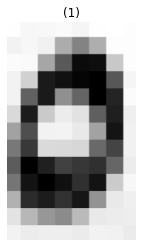

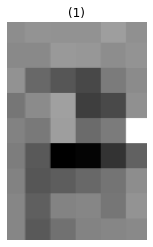

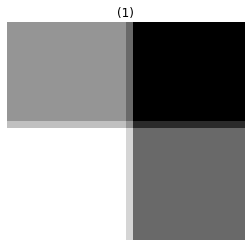

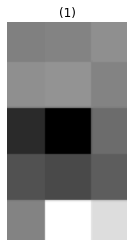

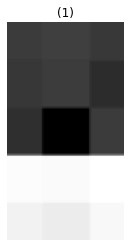

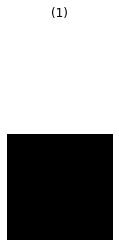

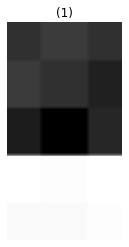

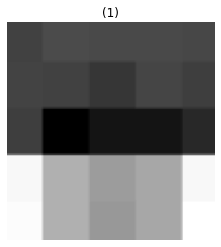

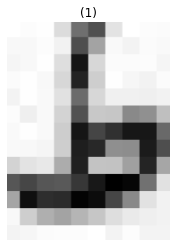

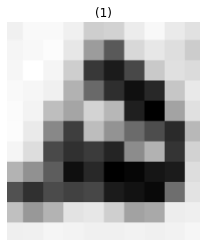

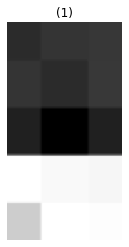

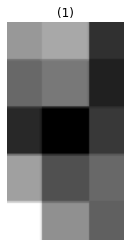

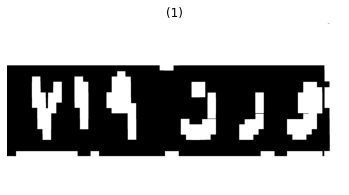

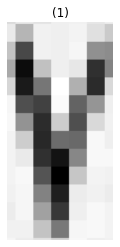

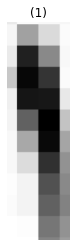

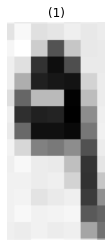

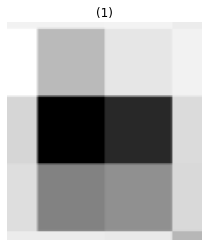

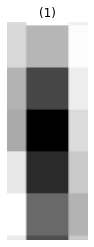

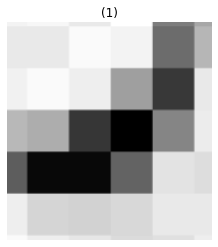

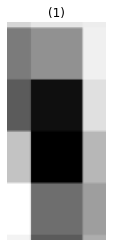

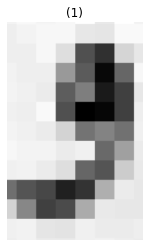

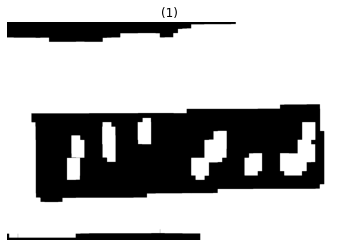

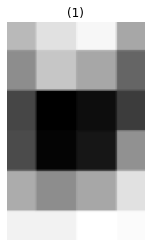

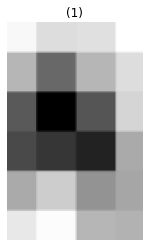

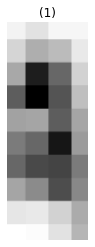

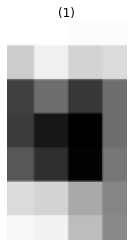

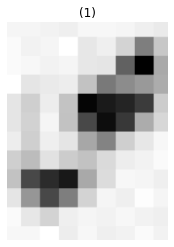

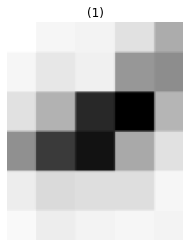

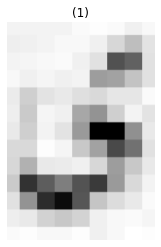

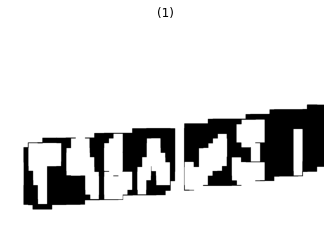

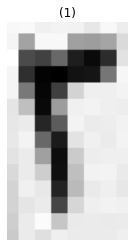

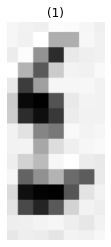

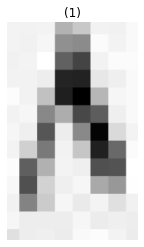

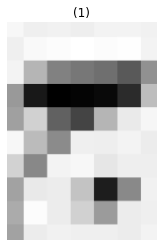

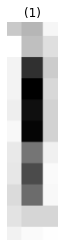

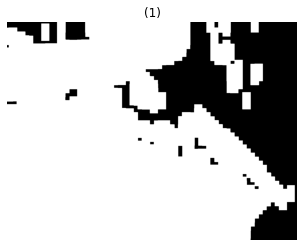

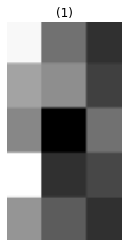

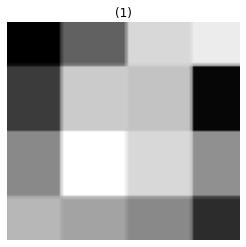

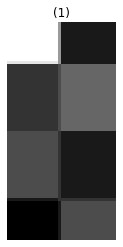

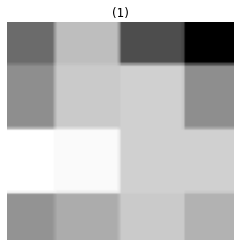

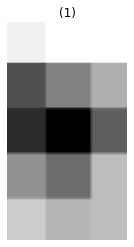

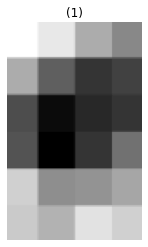

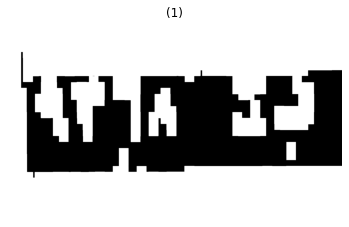

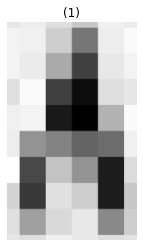

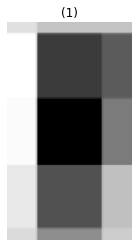

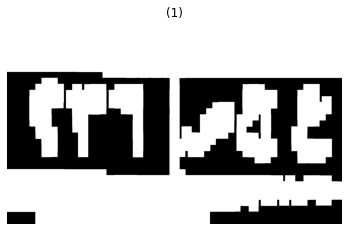

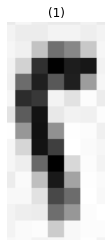

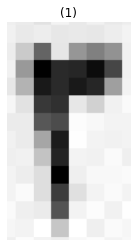

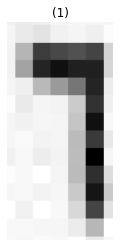

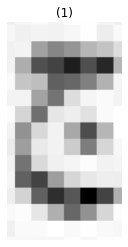

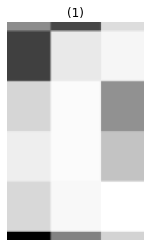

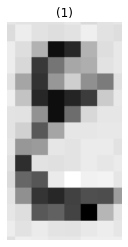

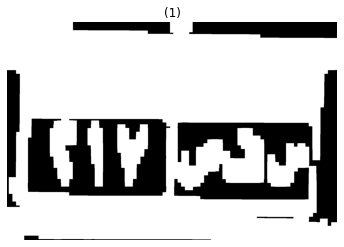

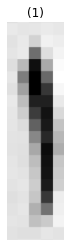

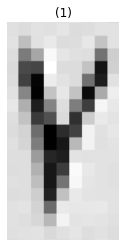

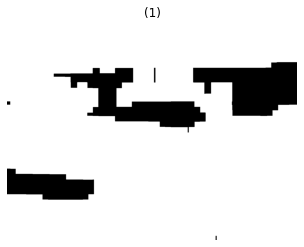

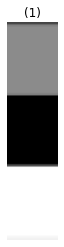

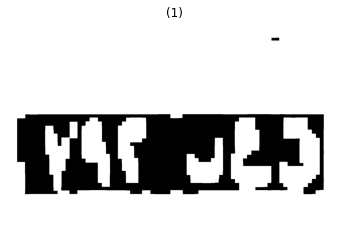

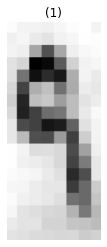

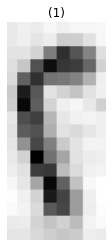

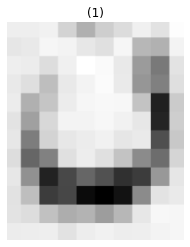

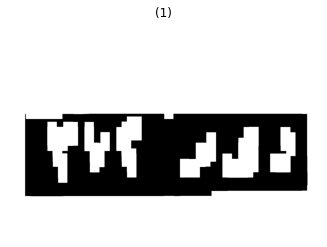

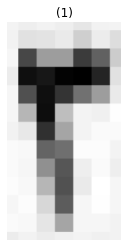

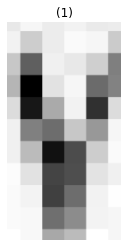

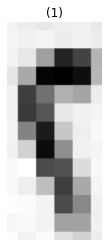

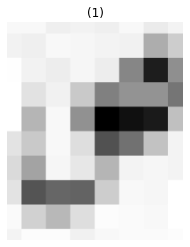

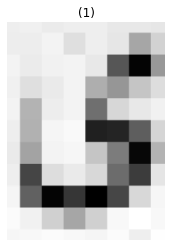

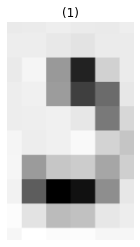

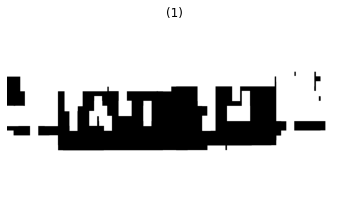

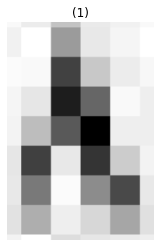

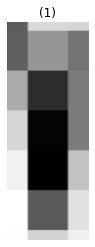

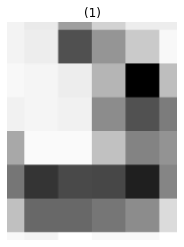

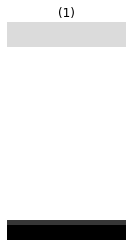

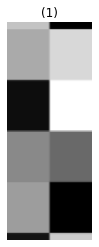

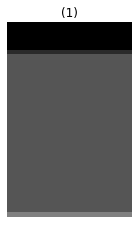

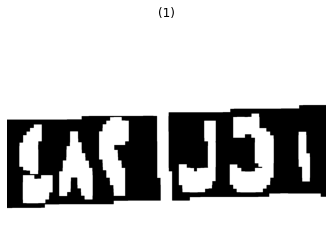

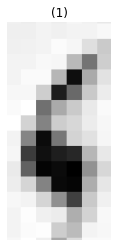

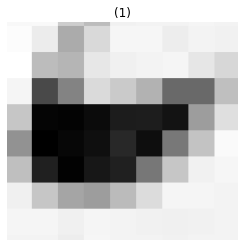

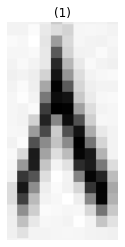

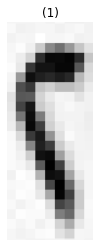

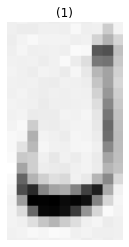

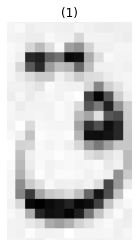

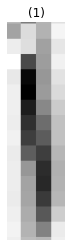

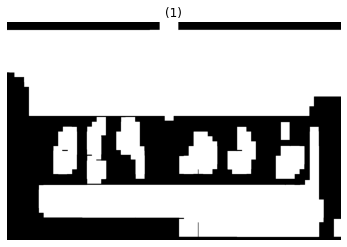

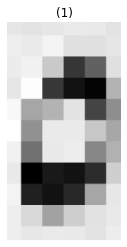

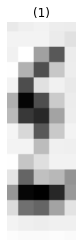

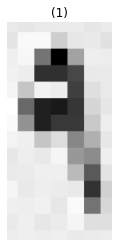

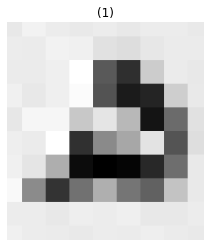

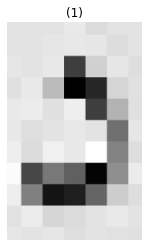

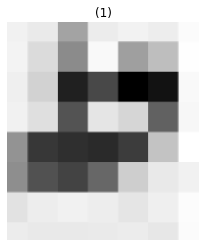

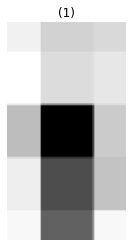

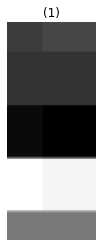

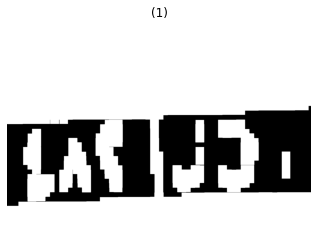

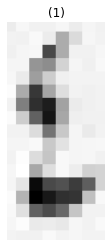

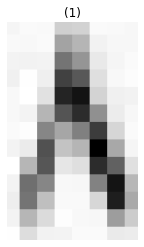

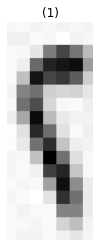

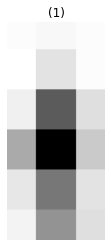

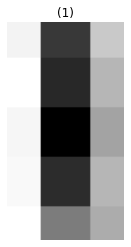

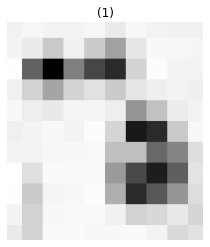

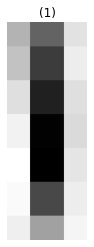

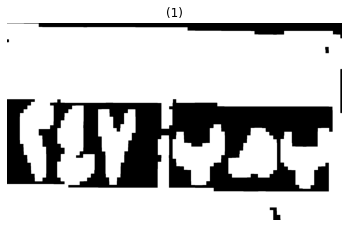

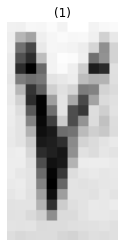

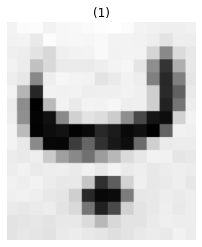

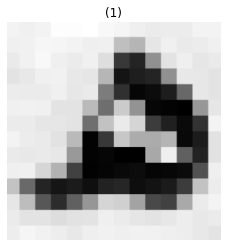

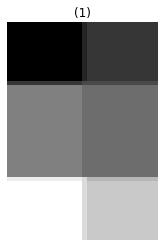

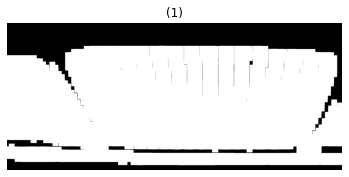

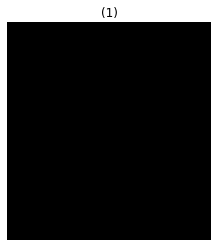

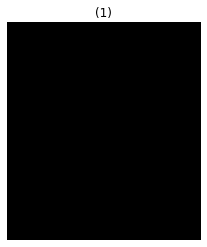

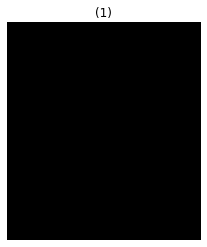

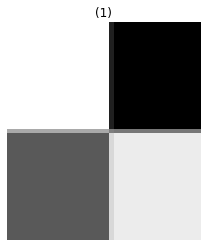

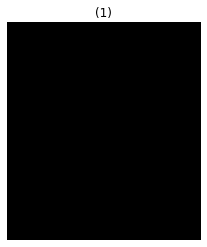

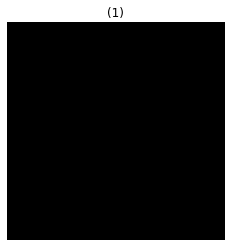

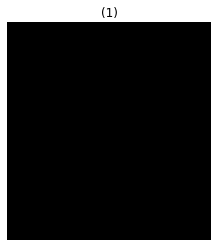

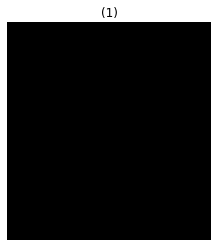

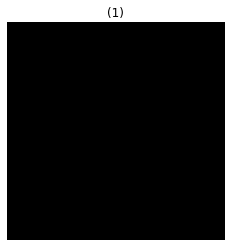

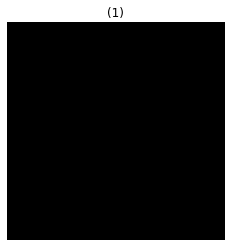

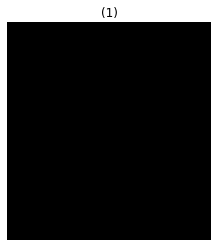

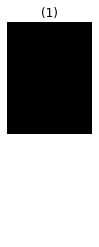

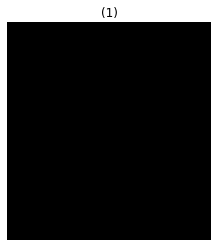

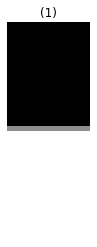

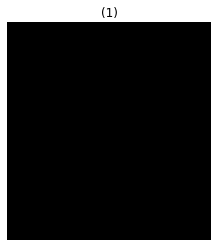

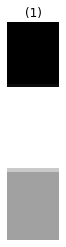

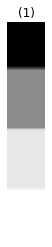

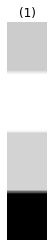

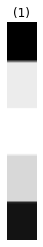

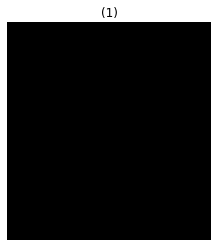

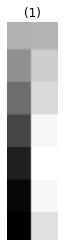

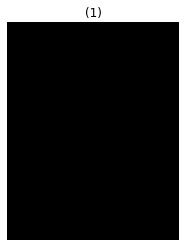

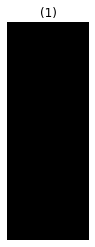

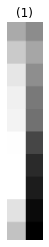

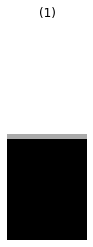

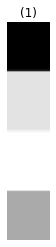

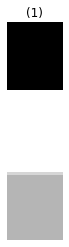

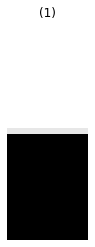

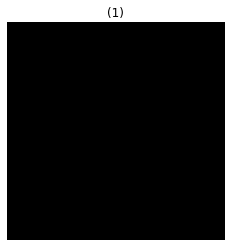

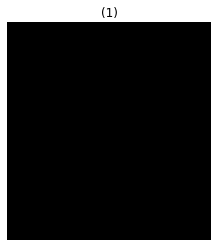

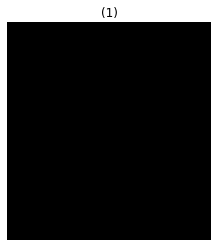

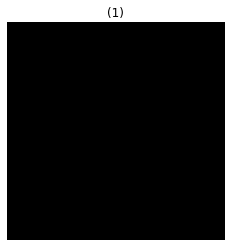

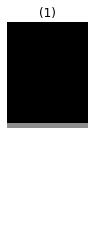

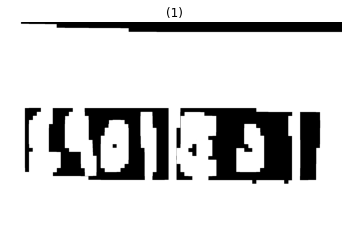

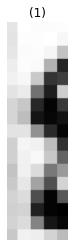

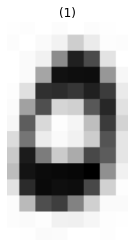

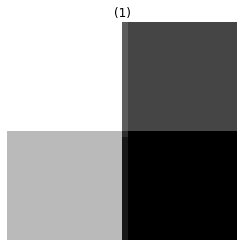

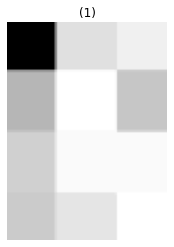

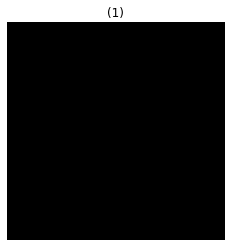

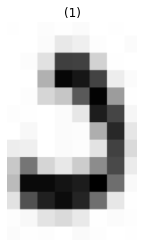

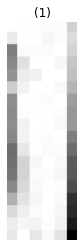

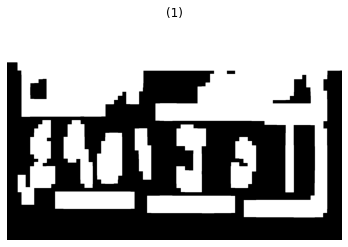

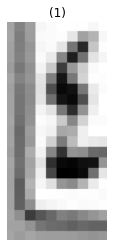

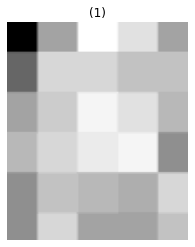

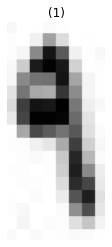

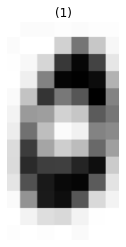

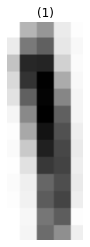

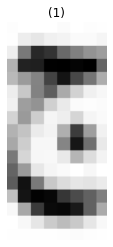

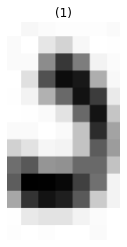

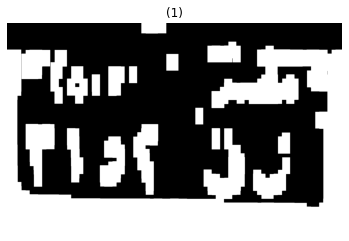

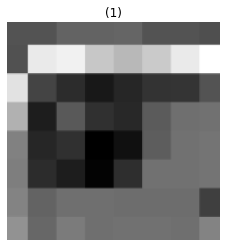

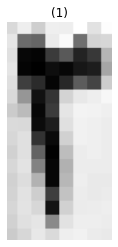

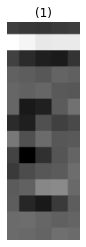

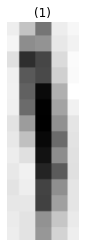

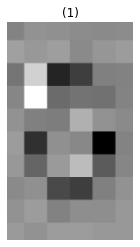

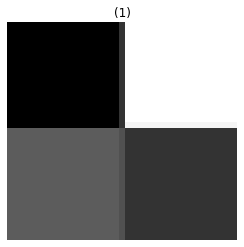

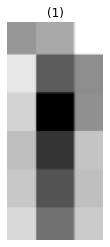

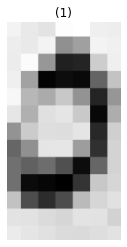

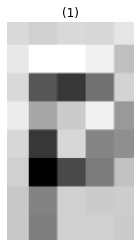

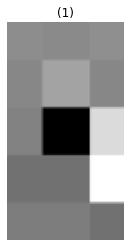

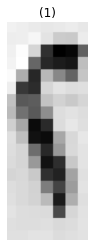

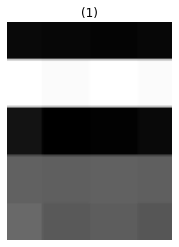

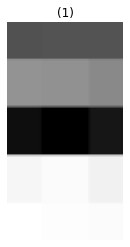

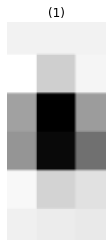

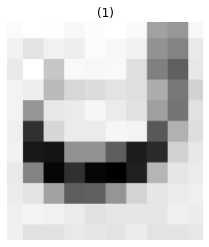

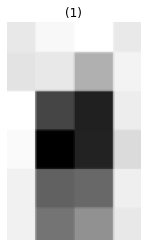

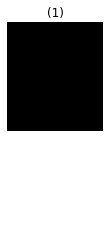

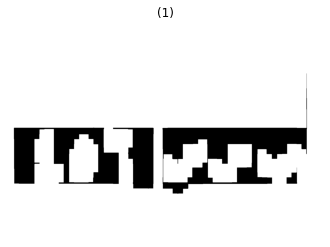

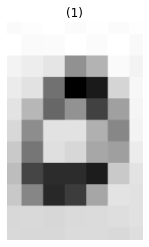

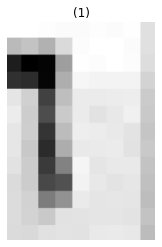

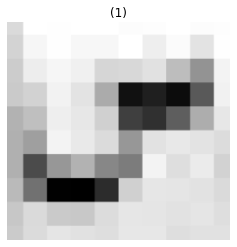

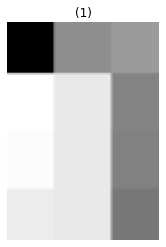

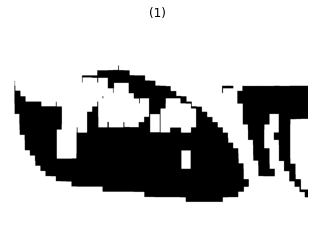

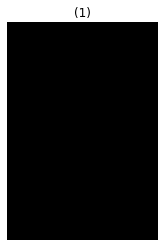

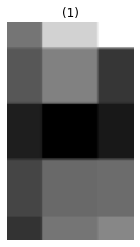

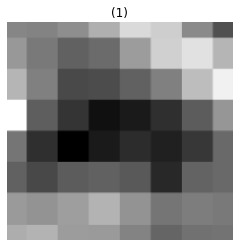

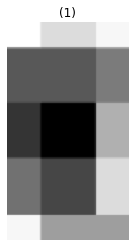

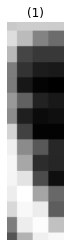

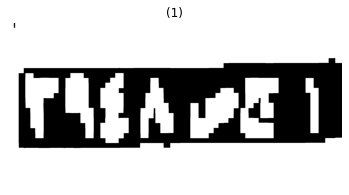

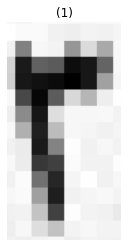

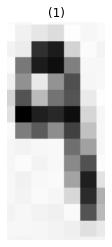

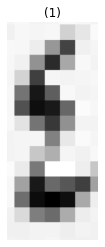

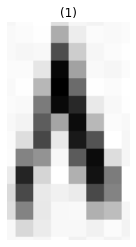

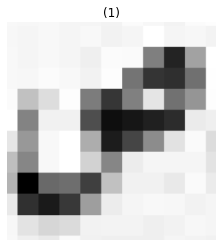

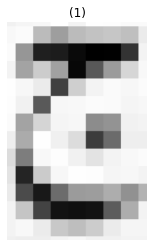

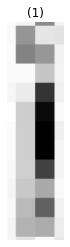

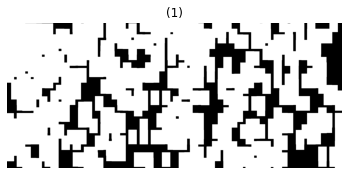

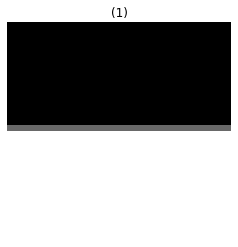

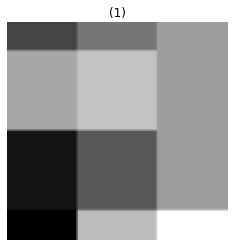

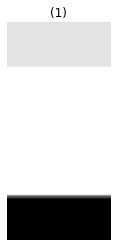

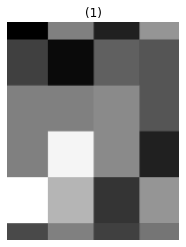

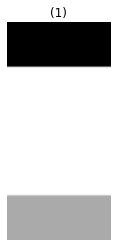

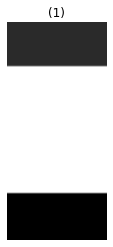

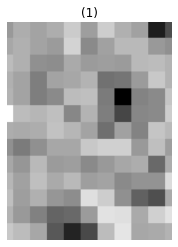

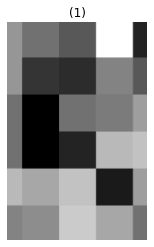

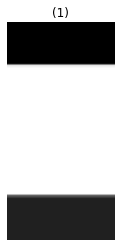

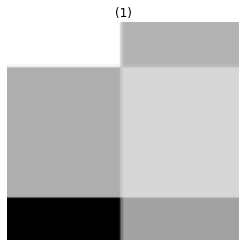

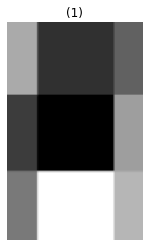

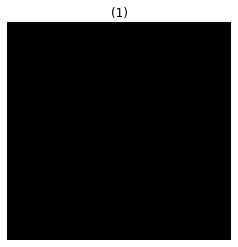

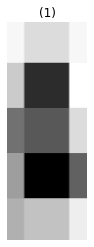

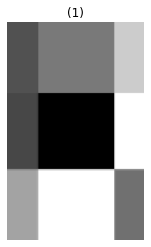

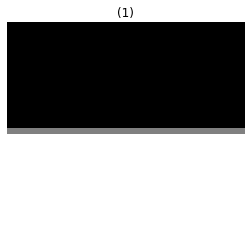

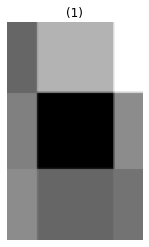

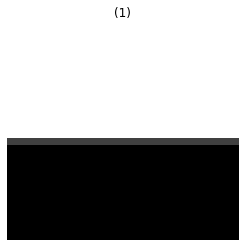

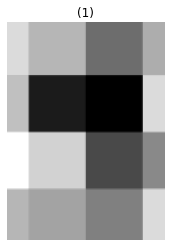

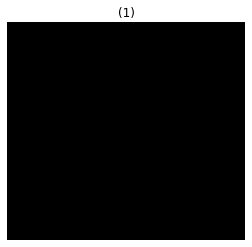

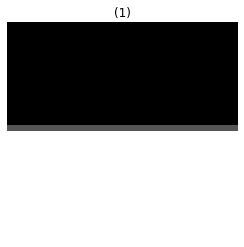

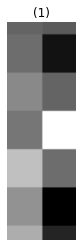

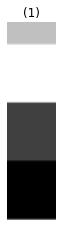

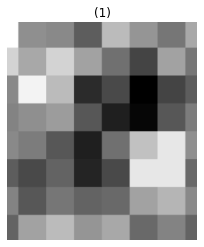

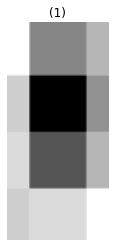

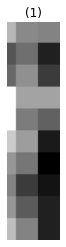

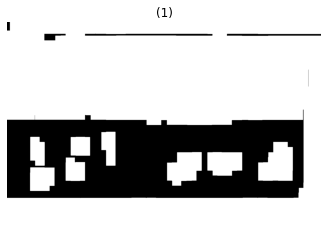

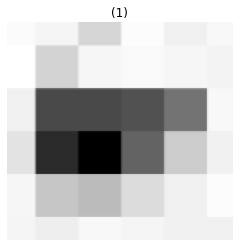

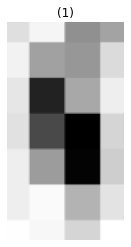

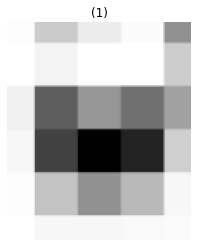

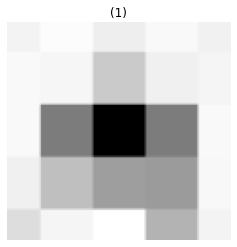

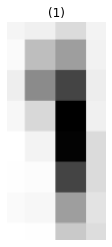

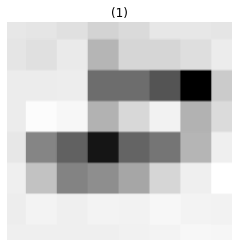

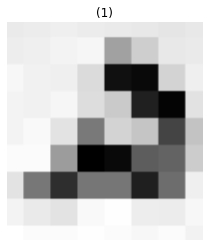

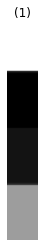

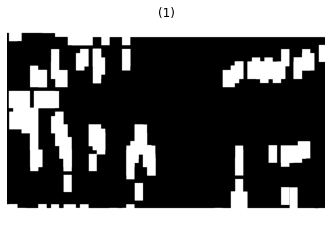

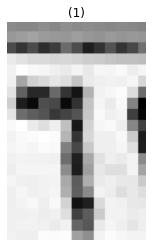

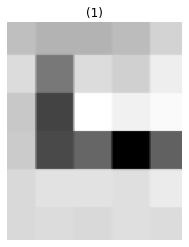

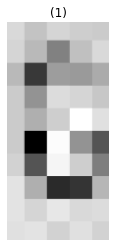

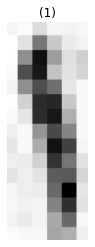

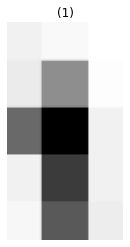

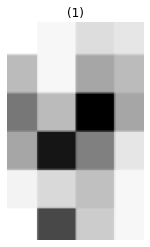

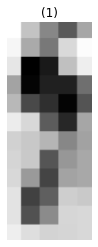

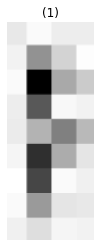

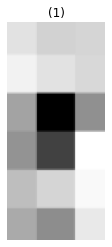

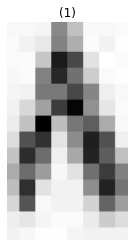

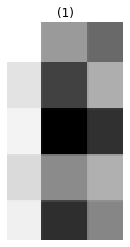

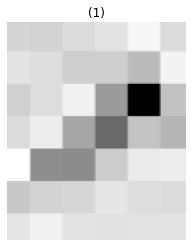

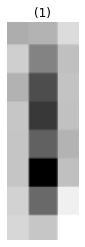

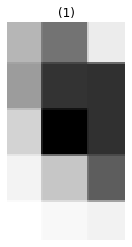

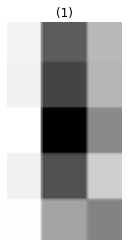

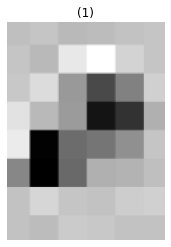

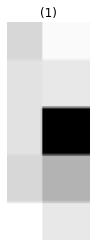

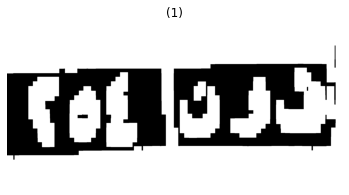

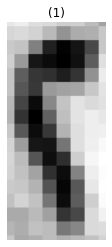

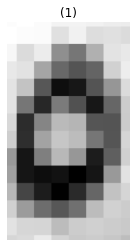

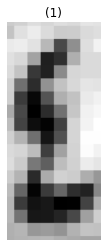

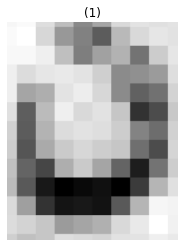

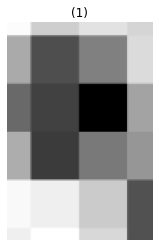

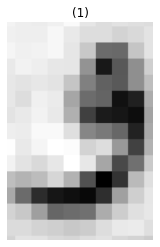

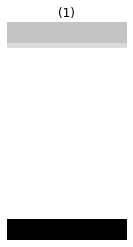

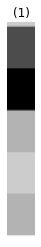

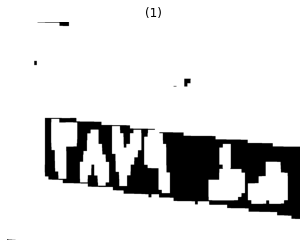

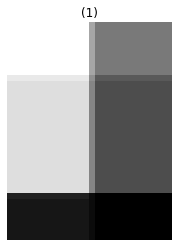

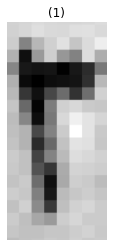

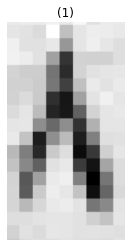

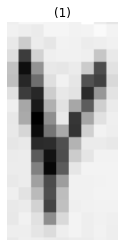

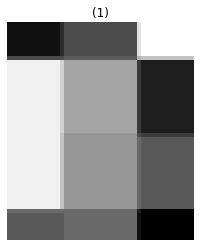

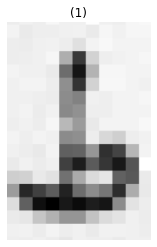

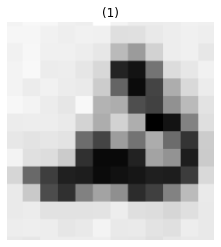

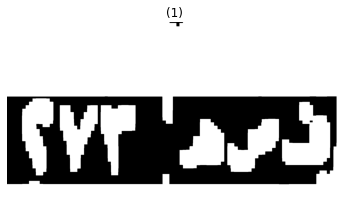

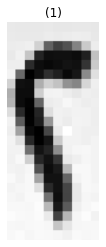

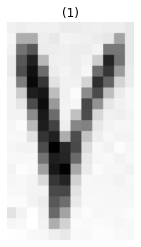

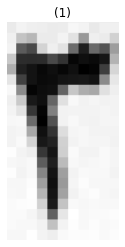

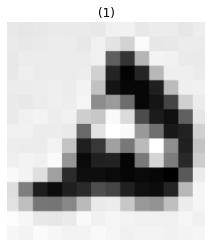

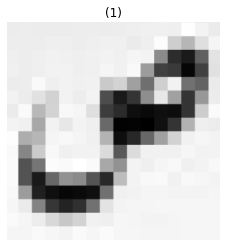

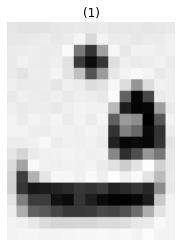

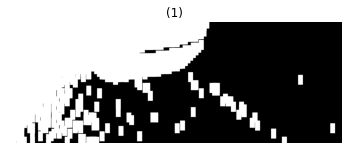

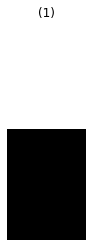

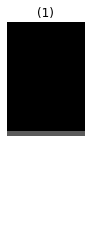

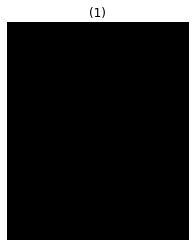

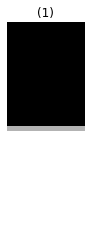

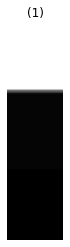

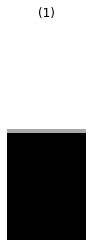

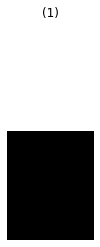

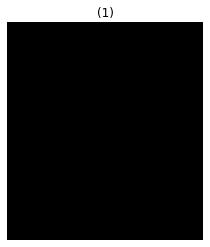

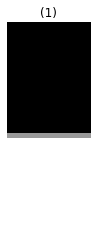

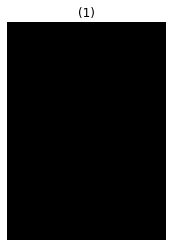

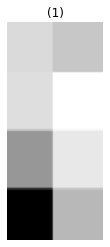

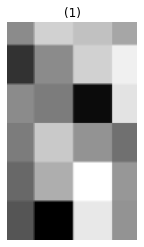

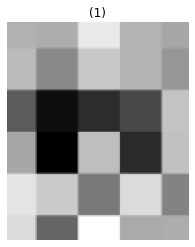

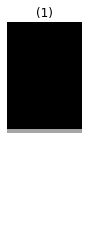

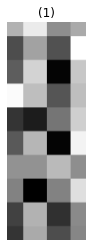

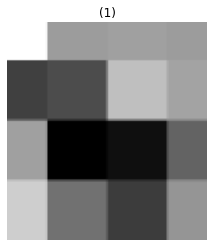

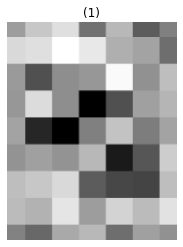

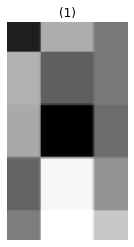

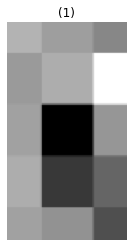

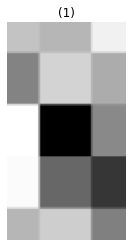

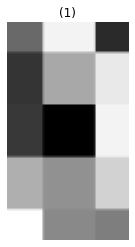

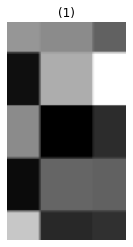

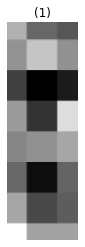

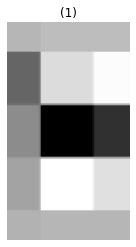

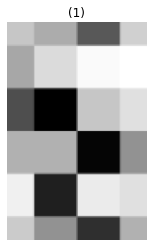

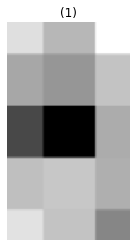

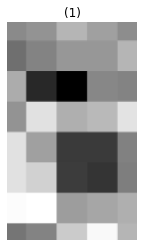

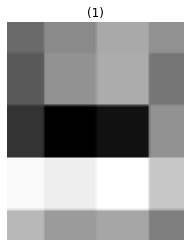

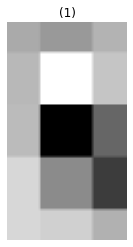

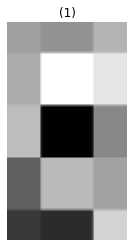

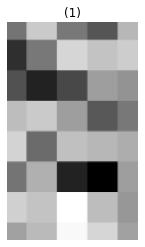

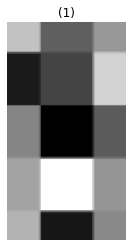

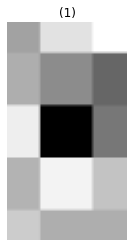

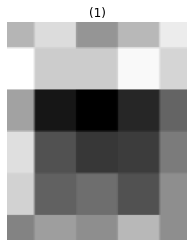

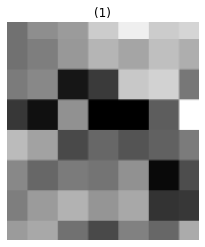

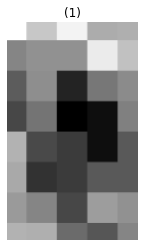

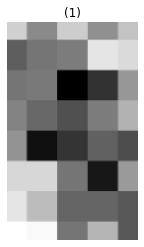

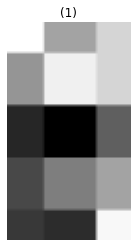

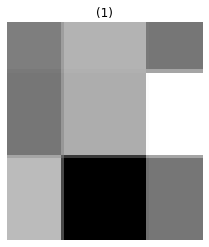

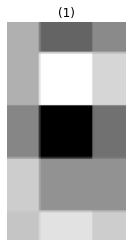

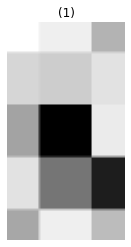

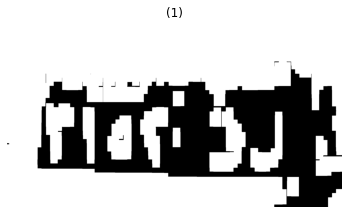

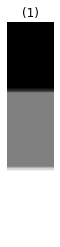

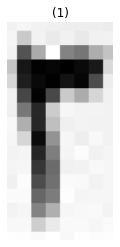

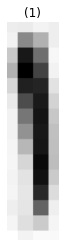

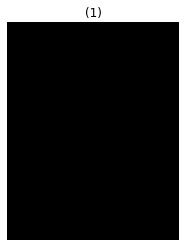

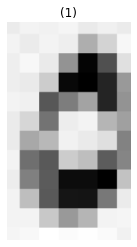

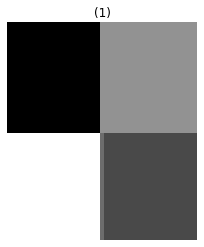

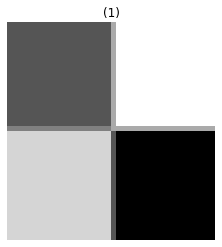

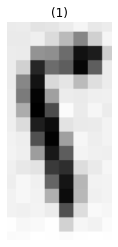

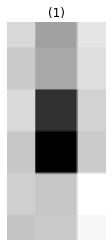

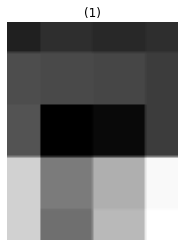

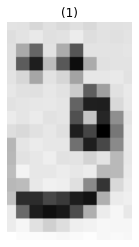

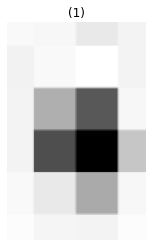

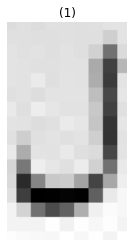

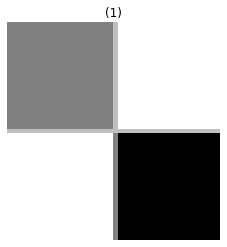

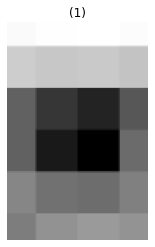

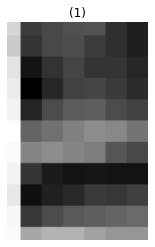

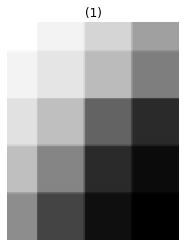

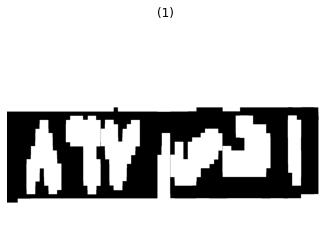

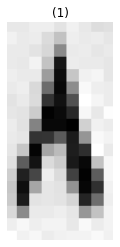

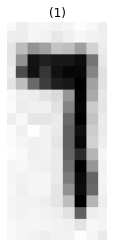

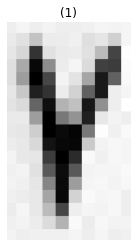

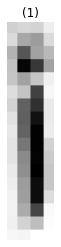

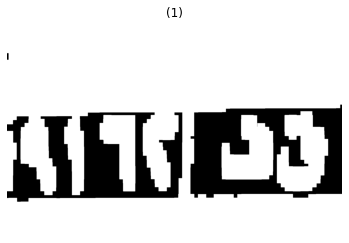

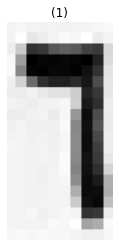

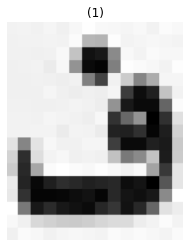

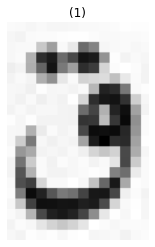

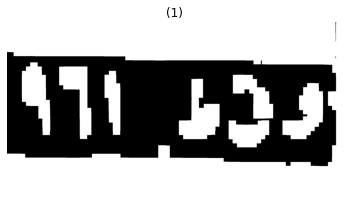

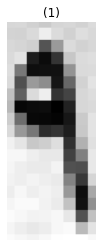

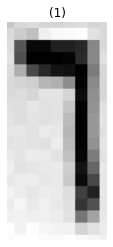

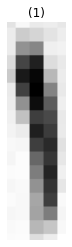

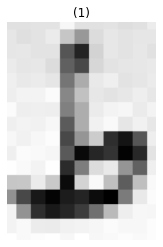

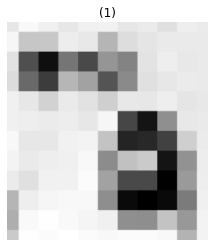

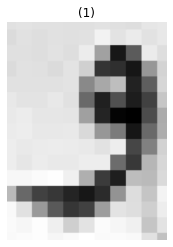

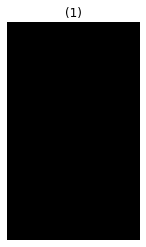

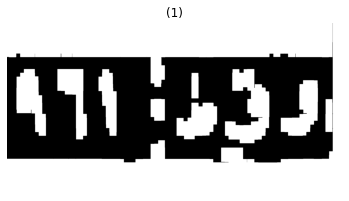

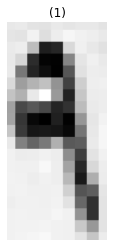

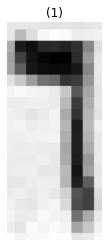

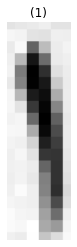

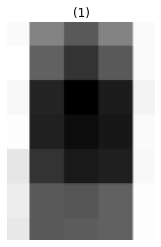

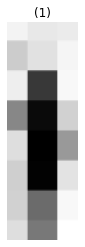

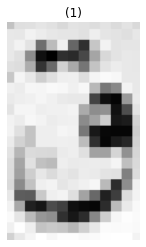

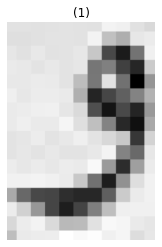

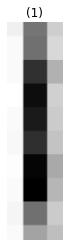

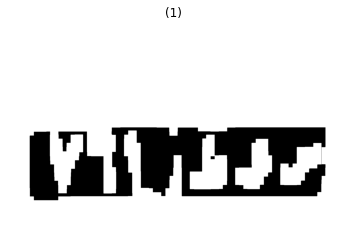

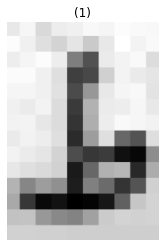

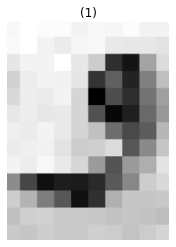

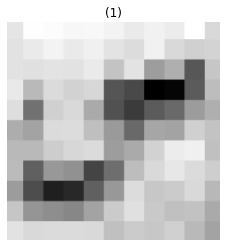

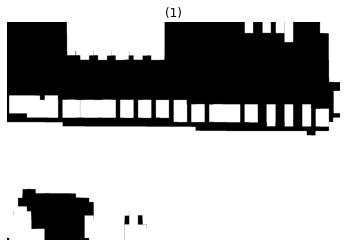

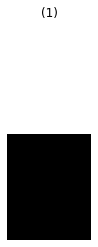

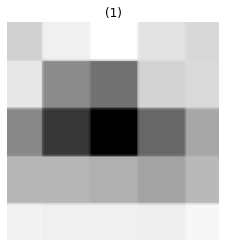

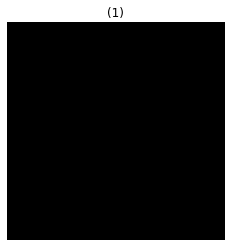

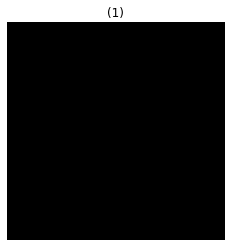

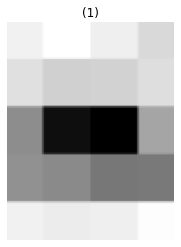

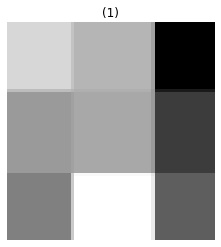

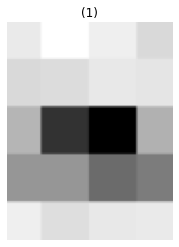

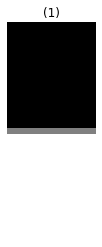

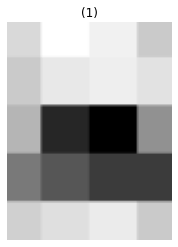

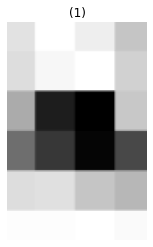

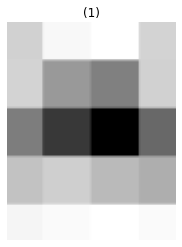

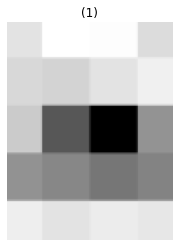

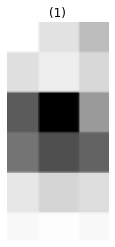

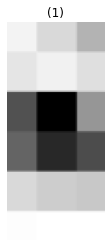

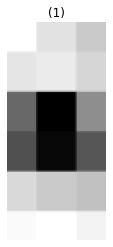

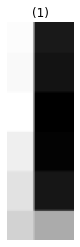

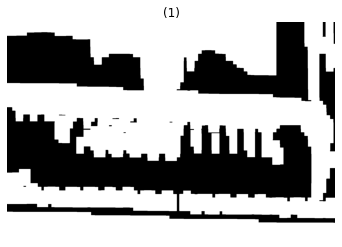

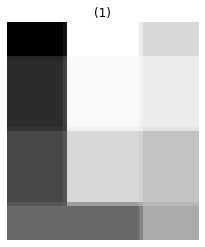

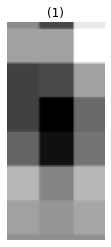

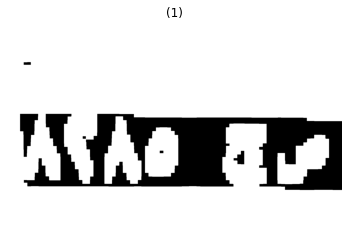

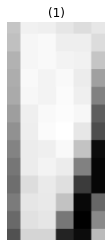

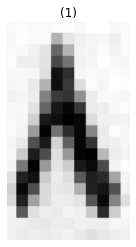

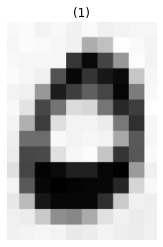

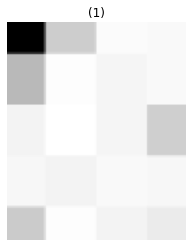

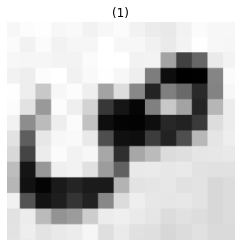

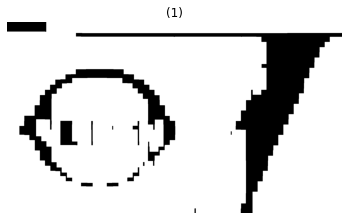

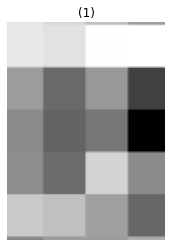

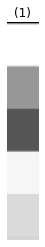

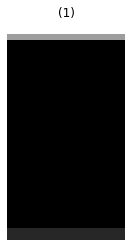

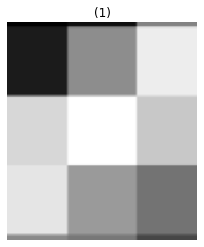

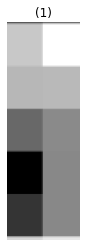

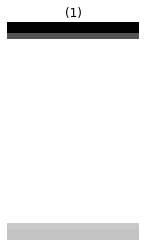

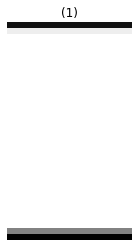

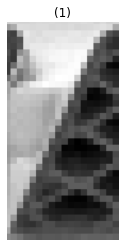

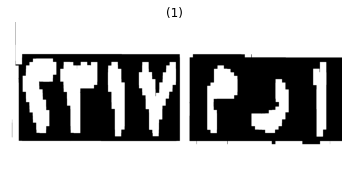

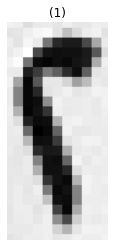

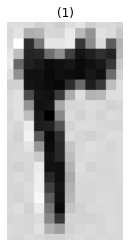

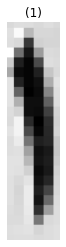

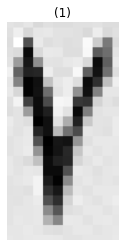

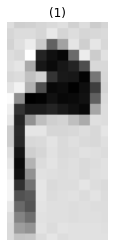

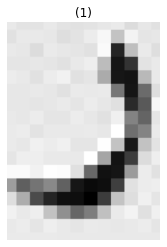

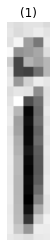

In [363]:
import os 
for imgName in os.listdir('plates'):
    plateImage=cv2.imread('plates/'+imgName,cv2.IMREAD_GRAYSCALE)
    txt = readPlate(plateImage)
    #if txt != "??":
        #show_images([plateImage])
        #print("text :  " + txt)